# Triangle Sports Analytics - Point Spread Modeling

This notebook builds and evaluates models for predicting NCAA basketball point spreads.

**Models to try:**
1. Baseline (team rating differential + home court advantage)
2. Linear Regression
3. Gradient Boosting (XGBoost)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
import sys
sys.path.insert(0, '..')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load team stats and games to predict
team_stats = pd.read_csv('../data/processed/team_stats_2025_26.csv')
games_df = pd.read_csv('../data/processed/games_to_predict.csv')

print(f"Team stats: {len(team_stats)} teams")
print(f"Games to predict: {len(games_df)} games")

# Create lookup dictionary for team stats
team_stats_dict = team_stats.set_index('team').to_dict('index')
team_stats.head()

Team stats: 21 teams
Games to predict: 78 games


,team,off_efficiency,def_efficiency,ppg,opp_ppg,pace,power_rating,win_pct
0,Michigan,128.038682,89.519084,89.627077,62.663359,70.0,38.519598,0.886108
1,Virginia,125.426670,96.646899,87.798669,67.652829,70.0,28.779771,0.848779
2,Duke,122.291265,96.012760,85.603885,67.208932,70.0,26.278504,0.825720
3,Louisville,124.807883,100.475606,87.365518,70.332925,70.0,24.332277,0.678327
4,Clemson,117.729038,95.678930,82.410327,66.975251,70.0,22.050108,0.773502


## 2. Feature Engineering

Create features for each game based on team statistics differentials.

In [3]:
# Home court advantage constant (typical in college basketball)
HOME_COURT_ADVANTAGE = 3.5

def get_team_stat(team, stat, default=0.0):
    """Safely get a team statistic"""
    try:
        return team_stats_dict[team][stat]
    except KeyError:
        return default

def create_game_features(home_team, away_team):
    """Create features for a single game"""
    features = {}
    
    # Basic stats differentials
    features['ppg_diff'] = get_team_stat(home_team, 'ppg', 72) - get_team_stat(away_team, 'ppg', 72)
    features['opp_ppg_diff'] = get_team_stat(away_team, 'opp_ppg', 72) - get_team_stat(home_team, 'opp_ppg', 72)
    
    # Efficiency differentials
    features['off_eff_diff'] = get_team_stat(home_team, 'off_efficiency', 100) - get_team_stat(away_team, 'off_efficiency', 100)
    features['def_eff_diff'] = get_team_stat(away_team, 'def_efficiency', 100) - get_team_stat(home_team, 'def_efficiency', 100)
    
    # Net efficiency
    home_net = get_team_stat(home_team, 'off_efficiency', 100) - get_team_stat(home_team, 'def_efficiency', 100)
    away_net = get_team_stat(away_team, 'off_efficiency', 100) - get_team_stat(away_team, 'def_efficiency', 100)
    features['net_eff_diff'] = home_net - away_net
    
    # Power rating differential
    features['power_rating_diff'] = get_team_stat(home_team, 'power_rating', 0) - get_team_stat(away_team, 'power_rating', 0)
    
    # Win percentage differential
    features['win_pct_diff'] = get_team_stat(home_team, 'win_pct', 0.5) - get_team_stat(away_team, 'win_pct', 0.5)
    
    # Home court advantage (always 1 for home team)
    features['is_home'] = 1
    
    return features

# Create features for all games
features_list = []
for idx, row in games_df.iterrows():
    features = create_game_features(row['Home'], row['Away'])
    features['home_team'] = row['Home']
    features['away_team'] = row['Away']
    features['date'] = row['Date']
    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created features for {len(features_df)} games")
features_df.head()

Created features for 78 games


,ppg_diff,opp_ppg_diff,off_eff_diff,def_eff_diff,net_eff_diff,power_rating_diff,win_pct_diff,is_home,home_team,away_team,date
0,7.493342,3.026288,10.704775,4.323269,15.028044,15.028044,0.259607,1,Virginia,Syracuse,2026-02-07
1,-6.799829,-0.822477,-9.714042,-1.174968,-10.889010,-10.889010,-0.137619,1,Wake Forest,Louisville,2026-02-07
2,5.024979,1.797457,7.178542,2.567795,9.746337,9.746337,0.067178,1,NC State,Virginia Tech,2026-02-07
3,-12.926392,-0.785892,-18.466274,-1.122702,-19.588977,-19.588977,-0.435198,1,Boston College,Miami,2026-02-07
4,-5.504295,-1.065195,-7.863279,-1.521707,-9.384986,-9.384986,-0.264059,1,Pitt,SMU,2026-02-07


## 3. Baseline Model: Power Rating + Home Court Advantage

The simplest model: Spread = (Home Power Rating - Away Power Rating) / 2 + HCA

In [4]:
def baseline_predict(home_team, away_team, hca=HOME_COURT_ADVANTAGE):
    """
    Simple baseline prediction:
    Spread = (Home Net Efficiency - Away Net Efficiency) / 2 + HCA
    
    Alternatively using power rating directly
    """
    home_power = get_team_stat(home_team, 'power_rating', 0)
    away_power = get_team_stat(away_team, 'power_rating', 0)
    
    # Power rating already represents expected margin per game
    spread = (home_power - away_power) / 2 + hca
    
    return spread

# Generate baseline predictions
baseline_predictions = []
for idx, row in games_df.iterrows():
    pred = baseline_predict(row['Home'], row['Away'])
    baseline_predictions.append(pred)

features_df['baseline_pred'] = baseline_predictions

# Show some example predictions
print("Sample Baseline Predictions:")
print("-" * 60)
sample_games = features_df[['home_team', 'away_team', 'baseline_pred']].head(10)
for _, row in sample_games.iterrows():
    if row['baseline_pred'] > 0:
        print(f"{row['home_team']} vs {row['away_team']}: {row['home_team']} by {row['baseline_pred']:.1f}")
    else:
        print(f"{row['home_team']} vs {row['away_team']}: {row['away_team']} by {-row['baseline_pred']:.1f}")

Sample Baseline Predictions:
------------------------------------------------------------
Virginia vs Syracuse: Virginia by 11.0
Wake Forest vs Louisville: Louisville by 1.9
NC State vs Virginia Tech: NC State by 8.4
Boston College vs Miami: Miami by 6.3
Pitt vs SMU: SMU by 1.2
Notre Dame vs Florida State: Notre Dame by 6.5
North Carolina vs Duke: North Carolina by 0.7
California vs Clemson: Clemson by 2.7
Stanford vs Georgia Tech: Stanford by 9.0
Louisville vs NC State: Louisville by 4.4


## 4. Visualize Predictions

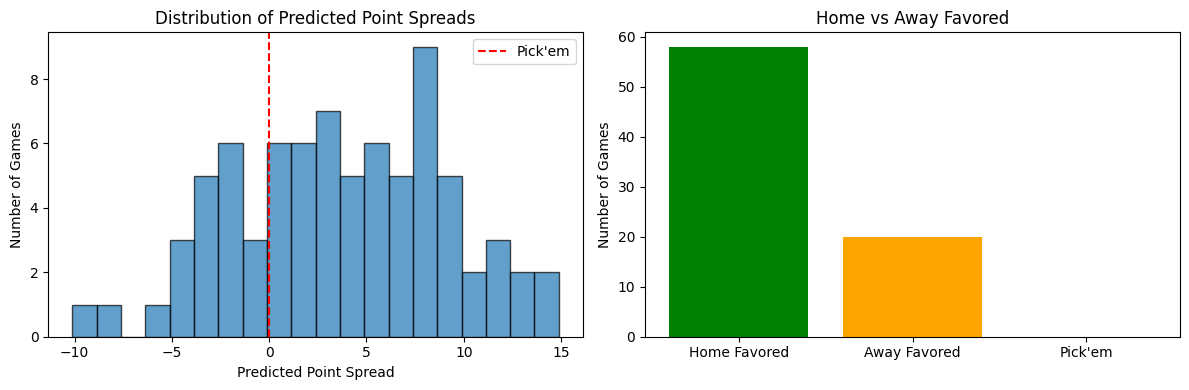


Summary:
  Home team favored: 58 games (74.4%)
  Away team favored: 20 games (25.6%)
  Average spread: 3.6 points


In [5]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of spreads
axes[0].hist(features_df['baseline_pred'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='Pick\'em')
axes[0].set_xlabel('Predicted Point Spread')
axes[0].set_ylabel('Number of Games')
axes[0].set_title('Distribution of Predicted Point Spreads')
axes[0].legend()

# Home vs Away favored
home_favored = (features_df['baseline_pred'] > 0).sum()
away_favored = (features_df['baseline_pred'] < 0).sum()
pickems = (features_df['baseline_pred'] == 0).sum()

axes[1].bar(['Home Favored', 'Away Favored', 'Pick\'em'], 
            [home_favored, away_favored, pickems], 
            color=['green', 'orange', 'gray'])
axes[1].set_ylabel('Number of Games')
axes[1].set_title('Home vs Away Favored')

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Home team favored: {home_favored} games ({100*home_favored/len(features_df):.1f}%)")
print(f"  Away team favored: {away_favored} games ({100*away_favored/len(features_df):.1f}%)")
print(f"  Average spread: {features_df['baseline_pred'].mean():.1f} points")

## 5. Generate Final Submission

Create the submission CSV file with predictions.

In [6]:
TEAM_NAME = "CMM"
TEAM_MEMBERS = ["Caleb Han", "Mason Mines"]
TEAM_EMAILS = ["calebhan@unc.edu", "mmines@unc.edu"]

# Load original template
original_template = pd.read_csv('../tsa_pt_spread_template_2026 - Sheet1.csv')

# Fill in predictions (only for rows with valid games)
submission = original_template.copy()

# Create prediction lookup
pred_lookup = {}
for idx, row in features_df.iterrows():
    key = (row['home_team'], row['away_team'])
    pred_lookup[key] = row['baseline_pred']

# Fill predictions
for idx, row in submission.iterrows():
    if pd.notna(row['Home']) and pd.notna(row['Away']):
        key = (row['Home'], row['Away'])
        if key in pred_lookup:
            submission.loc[idx, 'pt_spread'] = pred_lookup[key]

# Fill team info
for idx, member in enumerate(TEAM_MEMBERS):
    submission.loc[idx, 'team_members'] = member
for idx, email in enumerate(TEAM_EMAILS):
    submission.loc[idx, 'email'] = email
submission.loc[0, 'team_name'] = TEAM_NAME


# Preview
print("Submission Preview (first 10 rows):")
print(submission[['Date', 'Away', 'Home', 'pt_spread', 'team_name']].head(10))

print(f"\n✓ {submission['pt_spread'].notna().sum()} games have predictions")

Submission Preview (first 10 rows):
       Date           Away            Home  pt_spread team_name
0  2/7/2026       Syracuse        Virginia  11.014022       CMM
1  2/7/2026     Louisville     Wake Forest  -1.944505       NaN
2  2/7/2026  Virginia Tech        NC State   8.373169       NaN
3  2/7/2026          Miami  Boston College  -6.294488       NaN
4  2/7/2026            SMU            Pitt  -1.192493       NaN
5  2/7/2026  Florida State      Notre Dame   6.505978       NaN
6  2/7/2026           Duke  North Carolina   0.672646       NaN
7  2/7/2026        Clemson      California  -2.666720       NaN
8  2/7/2026   Georgia Tech        Stanford   9.017816       NaN
9  2/9/2026       NC State      Louisville   4.418922       NaN

✓ 78 games have predictions


In [7]:
# Save submission file
import os
os.makedirs('../data/predictions', exist_ok=True)

output_filename = f"tsa_pt_spread_{TEAM_NAME}_2026.csv"
output_path = f"../data/predictions/{output_filename}"

submission.to_csv(output_path, index=False)
print(f"✓ Saved submission to: {output_path}")

# Validation checks
print("\n" + "="*50)
print("SUBMISSION VALIDATION CHECKS")
print("="*50)

# Check 1: All 78 games have predictions
valid_games = submission.dropna(subset=['Date', 'Away', 'Home'])
games_with_preds = valid_games['pt_spread'].notna().sum()
print(f"[{'✓' if games_with_preds >= 78 else '✗'}] Games with predictions: {games_with_preds}/78")

# Check 2: No NaN predictions for valid games
nan_preds = valid_games['pt_spread'].isna().sum()
print(f"[{'✓' if nan_preds == 0 else '✗'}] No missing predictions: {nan_preds} missing")

# Check 3: Team info filled in
has_team_name = pd.notna(submission.loc[0, 'team_name']) and submission.loc[0, 'team_name'] != 'YourTeamName'
print(f"[{'✓' if has_team_name else '✗'}] Team name filled: {submission.loc[0, 'team_name']}")

# Check 4: Predictions are numeric
all_numeric = valid_games['pt_spread'].apply(lambda x: isinstance(x, (int, float))).all()
print(f"[{'✓' if all_numeric else '✗'}] All predictions numeric")

print("\n" + "="*50)
if games_with_preds >= 78 and nan_preds == 0 and has_team_name:
    print("🎉 READY FOR SUBMISSION!")
else:
    print("⚠️  Please fix the issues above before submitting")

✓ Saved submission to: ../data/predictions/tsa_pt_spread_CMM_2026.csv

SUBMISSION VALIDATION CHECKS
[✓] Games with predictions: 78/78
[✓] No missing predictions: 0 missing
[✓] Team name filled: CMM
[✓] All predictions numeric

🎉 READY FOR SUBMISSION!


## Next Steps

1. **Improve team stats**: Update `TEAM_STATS_PLACEHOLDER` in the data collection notebook with real data from:
   - [Sports Reference](https://www.sports-reference.com/cbb/)
   - [Barttorvik](https://barttorvik.com/)
   - [KenPom](https://kenpom.com/) (if you have access)

2. **Add more features**: Consider adding:
   - Recent form (last 5-10 games)
   - Head-to-head history
   - Days of rest between games
   - Travel distance

3. **Train on historical data**: If you can collect actual game results, train models with supervised learning

4. **Prediction intervals**: For bonus points, implement quantile regression